##### Imports

In [1]:
%matplotlib inline
from binance import Client, ThreadedWebsocketManager, ThreadedDepthCacheManager
import json
from binance import AsyncClient, DepthCacheManager, BinanceSocketManager
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import time

##### Connecting

In [2]:
file = open('API_CREDENTIALS.json',)
API_CREDENTIALS = json.load(file)

api_key = API_CREDENTIALS['api_key']
api_secret = API_CREDENTIALS['api_secret']

client = Client(api_key, api_secret)

In [3]:
# get all symbol prices
prices = client.get_all_tickers()


In [4]:
for item in prices:
    if item['symbol'] in ['BTCUSDT', 'ETHUSDT', 'ADABRL', 'ATOMUSDT', 'BRLUSDT', 'USDTBRL']:
        print(item)

{'symbol': 'BTCUSDT', 'price': '45926.04000000'}
{'symbol': 'ETHUSDT', 'price': '3158.23000000'}
{'symbol': 'ATOMUSDT', 'price': '15.16200000'}
{'symbol': 'USDTBRL', 'price': '5.30200000'}
{'symbol': 'ADABRL', 'price': '11.16700000'}


In [5]:
# [
#  [
#    1499040000000,      // Open time
#    "0.01634790",       // Open
#    "0.80000000",       // High
#    "0.01575800",       // Low
#    "0.01577100",       // Close
#    "148976.11427815",  // Volume
#    1499644799999,      // Close time
#    "2434.19055334",    // Quote asset volume
#    308,                // Number of trades
#    "1756.87402397",    // Taker buy base asset volume
#    "28.46694368",      // Taker buy quote asset volume
#    "17928899.62484339" // Ignore.
#  ]
#]

##### Plotting Graphs

In [3]:
%matplotlib inline
from binance import AsyncClient, DepthCacheManager, BinanceSocketManager
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def one_day_graph(ativo):

    klines = client.get_historical_klines(ativo, AsyncClient.KLINE_INTERVAL_1MINUTE, "1 day ago UTC")
    klines_close = [[kline[0],kline[4]] for kline in klines]
    first = klines_close[0][0]
    for item in klines_close:
        item[0] = item[0] - first
        item[0] = item[0] / 60000

    np_klines_close = np.array(klines_close)
    df_pandas = pd.DataFrame(np_klines_close, columns=['minute', 'price'])

    df_pandas['minute'] = df_pandas['minute'].astype(float)
    df_pandas['price'] = df_pandas['price'].astype(float)

    X = np.array(df_pandas['minute'])
    X = X[:, np.newaxis]
    y = np.array(df_pandas['price'])
    y = y[:, np.newaxis]

    model = LinearRegression().fit(X, y)

    df_pandas['y_'] = model.intercept_ + model.coef_ * X
    df_pandas['error'] = (df_pandas['price'] - df_pandas['y_'])**2

    mean = df_pandas['error'].mean()
    std = df_pandas['error'].std()
    df_pandas['error_normalized'] = (df_pandas['error'] - mean)/std

    a = np.array(df_pandas[((df_pandas['error_normalized'] > -3) & (df_pandas['error_normalized'] < 3)) == False]['minute'])
    b = np.array(df_pandas[((df_pandas['error_normalized'] > -3) & (df_pandas['error_normalized'] < 3)) == False]['price'])

    df_pandas['intercept_'] =  df_pandas['price']-(df_pandas['minute']*model.coef_[0][0])

    max = df_pandas[df_pandas['intercept_'] == df_pandas['intercept_'].max()][['minute','price']]
    max = [max.iloc[0]['minute'], max.iloc[0]['price']]
    top_x = np.array(df_pandas['minute'])
    intercept = max[1]-(max[0]*model.coef_)
    top_y = model.coef_*top_x + intercept
    top_y = top_y[0][:, np.newaxis]

    min = df_pandas[df_pandas['intercept_'] == df_pandas['intercept_'].min()][['minute','price']]
    min = [min.iloc[0]['minute'], min.iloc[0]['price']]
    bottom_x = np.array(df_pandas['minute'])
    intercept = min[1]-(min[0]*model.coef_)
    bottom_y = model.coef_*bottom_x + intercept
    bottom_y = bottom_y[0][:, np.newaxis]

    plt.figure(figsize=[16,9])
    plt.plot(df_pandas['minute'], df_pandas['price'], label=ativo)
    plt.plot(X, df_pandas['y_'], label="lin reg")
    plt.plot(top_x, top_y)
    plt.plot(bottom_x, bottom_y)
    plt.scatter(a, b, color='red')

    plt.title(ativo+" Price  [ÚLTIMAS 24H]", fontsize=18)
    plt.ylabel("price", fontsize=12)
    plt.xlabel("minutes", fontsize=12)
    plt.show()

    coef = model.coef_ *(df_pandas.iloc[-1]['minute'])
    coef = coef[0][0]

    intercept = model.intercept_
    #intercept = intercept[0][0]

    maximo =  df_pandas[df_pandas['price'] == df_pandas['price'].max()][['price']]
    maximo =  maximo.iloc[0]['price']

    minimo =  df_pandas[df_pandas['price'] == df_pandas['price'].min()][['price']]
    minimo =  minimo.iloc[0]['price']

    amplitude = maximo - minimo

    return_dict = {
      "coef": coef,
      "coef_": model.coef_,
      "intercept": intercept,
      "mean_error": mean,
      "std_error": std,
      "maximo": max[1],
      "amplitude": amplitude,
      "movimentacao": coef/maximo,
      "Z_score_error": 3,
      "first_minute": first,
      "last_minute": df_pandas.iloc[-1]["minute"]
    }

    return return_dict

In [42]:
from datetime import date

months_dict = {
    -1: 'Nov',
    0: 'Dec',
    1: 'Jan',
    2: 'Feb',
    3: 'Mar',
    4: 'Apr',
    5: 'May',
    6: 'Jun',
    7: 'Jul',
    8: 'Aug',
    9: 'Sep',
    10: 'Oct',
    11: 'Nov',
    12: 'Dec'
}

def two_months_graph(ativo):

    today = date.today()
    Y = today.strftime("%Y")
    m = today.strftime("%m")
    d = today.strftime("%d")

    hoje = d+" "+months_dict[int(m)]+", "+Y
    two_months_ago = d+" "+months_dict[int(m)-2]+", "+Y

    klines = client.get_historical_klines(ativo, Client.KLINE_INTERVAL_30MINUTE, two_months_ago, hoje)
    klines_close = [[kline[0],kline[4]] for kline in klines]
    first = klines_close[0][0]
    for item in klines_close:
        item[0] = item[0] - first
        item[0] = item[0] / 60000

    np_klines_close = np.array(klines_close)
    df_pandas = pd.DataFrame(np_klines_close, columns=['minute', 'price'])

    df_pandas['minute'] = df_pandas['minute'].astype(float)
    df_pandas['price'] = df_pandas['price'].astype(float)

    X = np.array(df_pandas['minute'])
    X = X[:, np.newaxis]
    y = np.array(df_pandas['price'])
    y = y[:, np.newaxis]

    model = LinearRegression().fit(X, y)

    df_pandas['y_'] = model.intercept_ + model.coef_ * X
    df_pandas['error'] = (df_pandas['price'] - df_pandas['y_'])**2

    mean = df_pandas['error'].mean()
    std = df_pandas['error'].std()
    df_pandas['error_normalized'] = (df_pandas['error'] - mean)/std

    a = np.array(df_pandas[((df_pandas['error_normalized'] > -3) & (df_pandas['error_normalized'] < 3)) == False]['minute'])
    b = np.array(df_pandas[((df_pandas['error_normalized'] > -3) & (df_pandas['error_normalized'] < 3)) == False]['price'])

    df_pandas['intercept_'] = df_pandas['price']-(df_pandas['minute']*model.coef_[0][0])

    max = df_pandas[df_pandas['intercept_'] == df_pandas['intercept_'].max()][['minute','price']]
    max = [max.iloc[0]['minute'], max.iloc[0]['price']]
    top_x = np.array(df_pandas['minute'])
    intercept = max[1]-(max[0]*model.coef_)
    top_y = model.coef_*top_x + intercept
    top_y = top_y[0][:, np.newaxis]

    min = df_pandas[df_pandas['intercept_'] == df_pandas['intercept_'].min()][['minute','price']]
    min = [min.iloc[0]['minute'], min.iloc[0]['price']]
    bottom_x = np.array(df_pandas['minute'])
    intercept = min[1]-(min[0]*model.coef_)
    bottom_y = model.coef_*bottom_x + intercept
    bottom_y = bottom_y[0][:, np.newaxis]

    plt.figure(figsize=[16,9])
    plt.plot(df_pandas['minute'], df_pandas['price'], label=ativo)
    plt.plot(X, df_pandas['y_'], label="lin reg")
    plt.plot(top_x, top_y)
    plt.plot(bottom_x, bottom_y)
    plt.scatter(a, b, color='red')

    plt.title(ativo+" Price [DOIS ÚLTIMOS MESES]", fontsize=18)
    plt.ylabel("price", fontsize=12)
    plt.xlabel("minutes", fontsize=12)
    plt.show()

    coef = model.coef_ *(df_pandas.iloc[-1]['minute'])
    coef = coef[0][0]

    maximo =  df_pandas[df_pandas['price'] == df_pandas['price'].max()][['price']]
    maximo =  maximo.iloc[0]['price']

    minimo =  df_pandas[df_pandas['price'] == df_pandas['price'].min()][['price']]
    minimo =  minimo.iloc[0]['price']

    amplitude = maximo - minimo

    return_dict = {
      "coef": coef,
      "maximo": max[1],
      "amplitude": amplitude,
      "movimentacao": coef/maximo
    }

    return return_dict


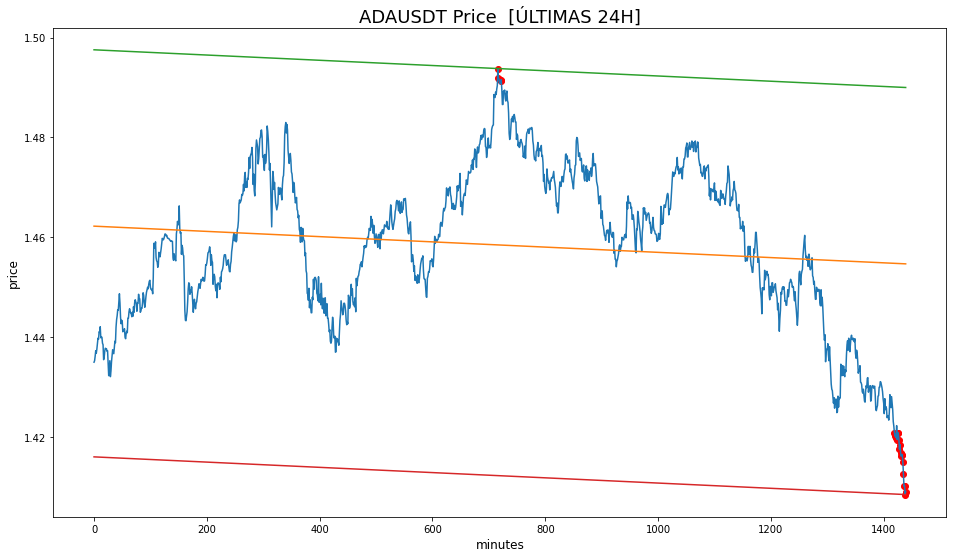

In [40]:
curto_prazo_dict = one_day_graph("ADAUSDT")

In [11]:
def tendencias(ativo):
    day_dict = one_day_graph(ativo)

    tendencia_day = "A DEFINIR"
    if day_dict['movimentacao'] > 0.01:
        tendencia_day = "ALTA"
    elif day_dict['movimentacao'] < -0.01:
        tendencia_day = "BAIXA"
    else:
        tendencia_day = "LATERAL"

    twomonths_dict =two_months_graph(ativo)

    tendencia_twomonths = "A DEFINIR"
    if twomonths_dict['movimentacao'] > 0.01:
        tendencia_twomonths = "ALTA"
    elif twomonths_dict['movimentacao'] < -0.01:
        tendencia_twomonths = "BAIXA"
    else:
        tendencia_twomonths = "LATERAL"

  
    print("TENDÊNCIA DE 1 DIA É "+tendencia_day)
    print("TENDÊNCIA DE 2 MESES É "+tendencia_twomonths)

    return [tendencia_day, tendencia_twomonths]


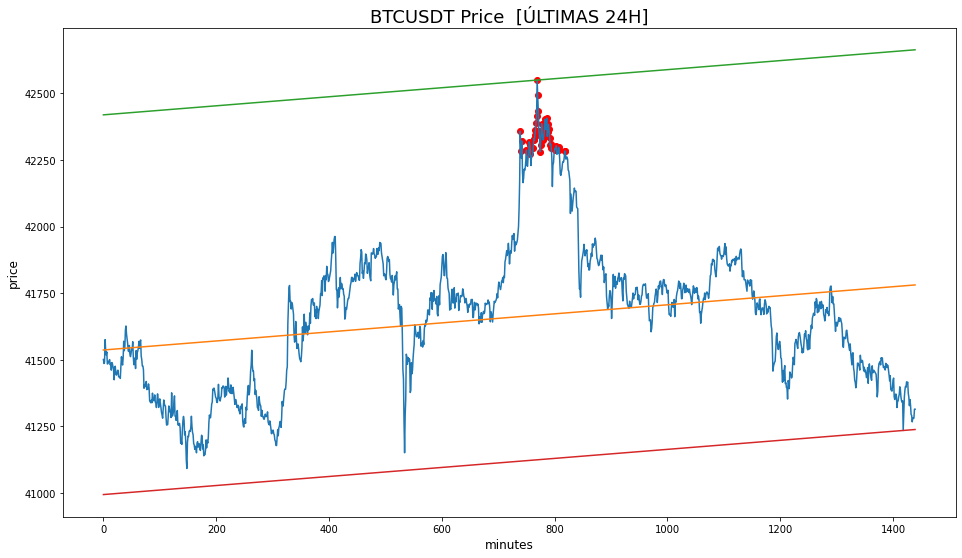

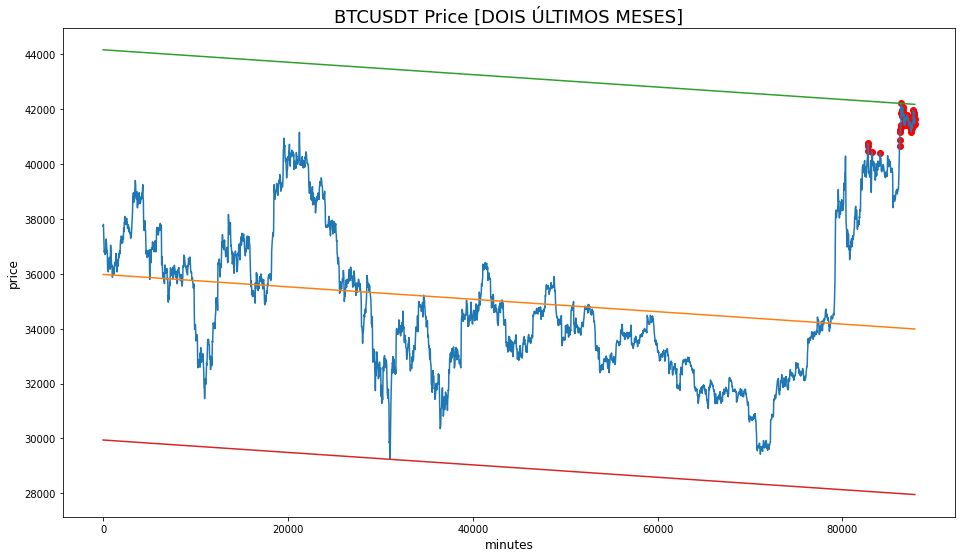

TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 2 MESES É BAIXA


['LATERAL', 'BAIXA']

In [13]:
tendencias("BTCUSDT")

**Backtest**

In [8]:
%matplotlib inline
from binance import AsyncClient, DepthCacheManager, BinanceSocketManager
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def four_days_graph_bt(ativo, klines):

    klines_close = [[kline[0],kline[4]] for kline in klines]
    first = klines_close[0][0]
    for item in klines_close:
        item[0] = item[0] - first
        item[0] = item[0] / 60000

    np_klines_close = np.array(klines_close)
    df_pandas = pd.DataFrame(np_klines_close, columns=['minute', 'price'])

    df_pandas['minute'] = df_pandas['minute'].astype(float)
    df_pandas['price'] = df_pandas['price'].astype(float)

    X = np.array(df_pandas['minute'])
    X = X[:, np.newaxis]
    y = np.array(df_pandas['price'])
    y = y[:, np.newaxis]

    model = LinearRegression().fit(X, y)

    df_pandas['y_'] = model.intercept_ + model.coef_ * X
    df_pandas['error'] = (df_pandas['price'] - df_pandas['y_'])

    mean = df_pandas['error'].mean()
    std = df_pandas['error'].std()
    df_pandas['error_normalized'] = (df_pandas['error'] - mean)/std

    a = np.array(df_pandas[((df_pandas['error_normalized'] > -3) & (df_pandas['error_normalized'] < 3)) == False]['minute'])
    b = np.array(df_pandas[((df_pandas['error_normalized'] > -3) & (df_pandas['error_normalized'] < 3)) == False]['price'])

    df_pandas['intercept_'] =  df_pandas['price']-(df_pandas['minute']*model.coef_[0][0])

    max = df_pandas[df_pandas['intercept_'] == df_pandas['intercept_'].max()][['minute','price']]
    max = [max.iloc[0]['minute'], max.iloc[0]['price']]
    top_x = np.array(df_pandas['minute'])
    intercept = max[1]-(max[0]*model.coef_)
    top_y = model.coef_*top_x + intercept
    top_y = top_y[0][:, np.newaxis]

    min = df_pandas[df_pandas['intercept_'] == df_pandas['intercept_'].min()][['minute','price']]
    min = [min.iloc[0]['minute'], min.iloc[0]['price']]
    bottom_x = np.array(df_pandas['minute'])
    intercept = min[1]-(min[0]*model.coef_)
    bottom_y = model.coef_*bottom_x + intercept
    bottom_y = bottom_y[0][:, np.newaxis]

    coef = model.coef_ *(df_pandas.iloc[-1]['minute'])
    coef = coef[0][0]

    intercept = model.intercept_

    maximo =  df_pandas[df_pandas['price'] == df_pandas['price'].max()][['price']]
    maximo =  maximo.iloc[0]['price']

    minimo =  df_pandas[df_pandas['price'] == df_pandas['price'].min()][['price']]
    minimo =  minimo.iloc[0]['price']

    amplitude = maximo - minimo

    return_dict = {
      "coef": coef,
      "coef_": model.coef_,
      "intercept": intercept,
      "mean_error": mean,
      "std_error": std,
      "maximo": max[1],
      "amplitude": amplitude,
      "movimentacao": coef/maximo,
      "Z_score_error": 3,
      "first_minute": first,
      "last_minute": df_pandas.iloc[-1]["minute"]
    }

    return return_dict

In [9]:
def tendencias_bt(ativo, klines):
    four_days_dict = four_days_graph_bt(ativo, klines)

    tendencia_four_days = "A DEFINIR"
    if four_days_dict['movimentacao'] > 0.01:
        tendencia_four_days = "ALTA"
    elif four_days_dict['movimentacao'] < -0.01:
        tendencia_four_days = "BAIXA"
    else:
        tendencia_four_days = "LATERAL"

    print("TENDÊNCIA DE 1 DIA É "+tendencia_four_days)


    return tendencia_four_days

In [10]:
lastPeriodInMins = client.get_historical_klines("ADAUSDT", AsyncClient.KLINE_INTERVAL_1MINUTE, "1 year ago UTC")

In [14]:
# SETS
op_list = []
sellSignal = 0
buySignal = 0
comprado = False
vendido = False


# START
# Calcular regressões 2 meses e um dia
tendencia_four_days = tendencias_bt("ADAUSDT", lastPeriodInMins[(86400-5040):86400])
four_days_dict = four_days_graph_bt("ADAUSDT", lastPeriodInMins[(86400-5040):86400])

for i in range (86400, len(lastPeriodInMins)):
  # A CADA MINUTO:
  # Olhar o preço do Ativo
    ultimoCandle_data = lastPeriodInMins[i]
    #ultimoCandle = client.get_historical_klines("ADAUSDT", AsyncClient.KLINE_INTERVAL_1MINUTE, "1 minute ago UTC")
    ultimoCandle = [ultimoCandle_data[0], float(ultimoCandle_data[4])]
    currentMinute = ultimoCandle[0] / 60000
    ultimoCandle[0] = ultimoCandle[0] - four_days_dict["first_minute"]
    ultimoCandle[0] = ultimoCandle[0] / 60000

    yLinReg_lastCandle = four_days_dict["coef_"] * ultimoCandle[0] + four_days_dict["intercept"]
    error_lastCandle = (ultimoCandle[1] - yLinReg_lastCandle)
    zScore_lastCandle = (error_lastCandle - four_days_dict["mean_error"])/ four_days_dict["std_error"]

    if(not comprado and not vendido):
        if((zScore_lastCandle > four_days_dict["Z_score_error"]) and (tendencia_four_days == "BAIXA")): # and (tendencia_two_months != "ALTA")):
            print("SINAL DE VENDA")
            sellSignal = 1

    if((sellSignal == 1)):
        # SELL
        buy_price = ultimoCandle[1]
        comprado = True
        diff1 = ultimoCandle[1] - yLinReg_lastCandle 
        TP = yLinReg_lastCandle - 0.4*diff1 #- 0.4*diff1  #0.5 * four_days_dict["std_error"]
        diff = (ultimoCandle[1] - TP)
        STOP = ultimoCandle[1] + diff/2
        sellSignal = 0
        print("COMPRANDO")
        TP = TP[0][0]
        STOP = STOP[0][0]
        
        aux = TP
        TP = STOP
        STOP = aux
        
        op_time = currentMinute

    if(comprado and ((ultimoCandle[1] >= TP) or (ultimoCandle[1] <= STOP))):
        # Sai da Operacao
        saida_price = ultimoCandle[1]
        if(saida_price >= buy_price):
                situacao = "GAIN"
                lucro = saida_price - buy_price
        if(saida_price < buy_price):
                situacao = "LOSS"
                lucro = saida_price - buy_price
        op_list.append([situacao,currentMinute - op_time, lucro, "BUY", buy_price, saida_price, TP, STOP, 30])

        comprado = False
        print("SAINDO DA OPERACAO DE COMPRA")

    if(i % 210 == 0):
        tendencia_four_days = tendencias_bt("ADAUSDT", lastPeriodInMins[i - 5040:i])
        four_days_dict = four_days_graph_bt("ADAUSDT", lastPeriodInMins[i - 5040:i])
        sellSignal = 0
        buySignal = 0
        
    #if(i % 1440 == 0):
    #    tendencia_two_months = tendencias_2m_bt("ADAUSDT", lastPeriodInMins[i - 86400:i])
    #    sellSignal = 0
    #    buySignal = 0
#SLEEP 1 MIN


# se for uma anomalia e a operação estiver alinhada com a tendência, entrar em operação
# caso não, esperar o próximo minuto

# Caso tenha entrado na operação
# Definir o intervalo de preço p/ permanecer na operação
# Se sair do intervalo, realizar operação inversa

# A CADA HORA:
# Refazer a Regressão


TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
SINAL DE VENDA
COMPRANDO
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
SAINDO DA OPERACAO DE COMPRA
TENDÊNCIA DE 1 DIA É A

TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
SINAL DE VENDA
COMPRANDO
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É A

TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TEND

TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
SINAL DE VENDA
COMPRANDO
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É ALTA
SAINDO DA OPERACAO DE COMPRA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA

TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É LATERAL
SAINDO DA OPERACAO DE COMPRA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É ALTA

TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
SINAL DE VENDA
COMPRANDO
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
SAINDO DA OPERACAO DE COMPRA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
SINAL DE VENDA
COMPRANDO
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
SAINDO DA OPERACAO DE COMPRA
T

TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
SINAL DE VENDA
COMPRANDO
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É BAIXA
TENDÊNCIA DE 1 DIA É LATERAL
SAINDO DA OPERACAO DE COMPRA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 DIA É LATERAL
TENDÊNCIA DE 1 D

TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA
TENDÊNCIA DE 1 DIA É ALTA


In [15]:
data = np.array(op_list)

In [16]:
df = pd.DataFrame(data,index=data[:,0], columns=['Situação', 'Tempo na Operação', 'Lucro', 'Tipo', 'Preço Entrada', 'Preço Saída', 'TP', 'STOP', 'Qtde'])

In [17]:
df["Tempo na Operação"] = df["Tempo na Operação"].astype(float)
df["Lucro Vezes Qtde"] = df["Lucro"].astype(float) * df["Qtde"].astype(float) 

In [18]:
df["Comission"] = (df["Preço Entrada"].astype(float) * df["Qtde"].astype(float) * 0.0015) +  (df["Preço Saída"].astype(float) * df["Qtde"].astype(float) * 0.0015)

In [19]:
df

,Situação,Tempo na Operação,Lucro,Tipo,Preço Entrada,Preço Saída,TP,STOP,Qtde,Lucro Vezes Qtde,Comission
GAIN,GAIN,3311.0,0.0024100000000000094,BUY,0.10601,0.10842,0.10819980799324187,0.10163038401351623,30,0.0723,0.009649
LOSS,LOSS,1790.0,-0.007849999999999996,BUY,0.09851,0.09066,0.10234586097542828,0.09083827804914346,30,-0.2355,0.008513
GAIN,GAIN,809.0,0.0023899999999999894,BUY,0.10419,0.10658,0.10641751148201264,0.09973497703597473,30,0.0717,0.009485
GAIN,GAIN,312.0,0.003239999999999993,BUY,0.10673,0.10997,0.10996044020880832,0.10026911958238338,30,0.0972,0.009751
GAIN,GAIN,410.0,0.003930000000000003,BUY,0.11139,0.11532,0.11510289584935589,0.10396420830128823,30,0.1179,0.010202
GAIN,GAIN,270.0,0.005659999999999998,BUY,0.11483,0.12049,0.12043477655738655,0.10362044688522691,30,0.1698,0.010589
GAIN,GAIN,27670.0,0.020360000000000017,BUY,0.15569,0.17605,0.17598180175622274,0.11510639648755448,30,0.6108,0.014928
GAIN,GAIN,4962.0,0.014020000000000005,BUY,0.16382,0.17784,0.17717916581618467,0.13710166836763063,30,0.4206,0.015375
LOSS,LOSS,243.0,-0.01197999999999999,BUY,0.18336,0.17138,0.1892149403328029,0.17165011933439417,30,-0.3594,0.015963
GAIN,GAIN,26.0,0.006519999999999998,BUY,0.18394,0.19046,0.19027475348482467,0.17127049303035063,30,0.1956,0.016848


In [20]:
pd.set_option('display.max_rows', 1000)

In [21]:
df['Lucro Vezes Qtde'].astype(float).sum()

22.43700000000001

In [22]:
df['Comission'].astype(float).sum()

3.1509989999999997